Computing orthogonal polynomials using Gram-Schmidt for general cases:

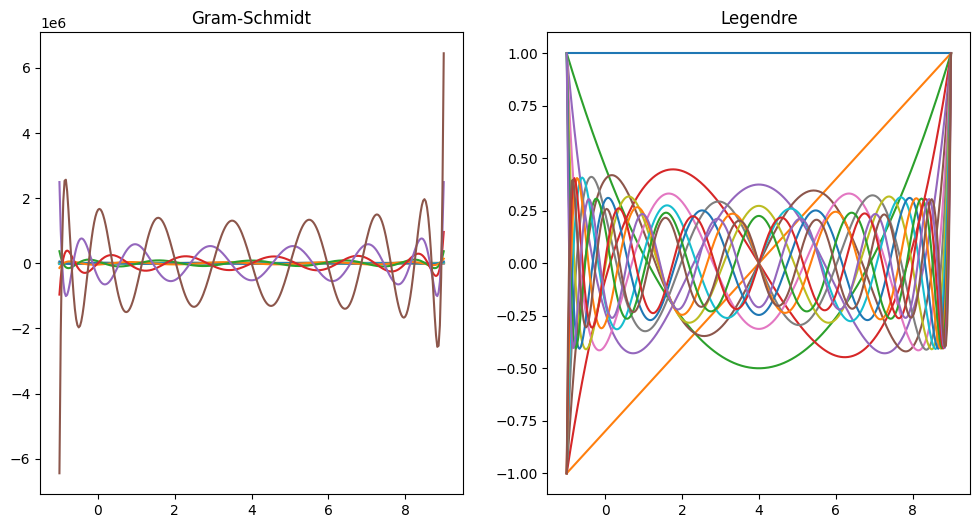

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre
from scipy.integrate import quad

class LeastSquares:
    """Approximate a function f(x) using a polynomial of degree n through Least Squares Algorithm."""
    phi = []
    c =  []

    def __init__(self, f, a, b, n, 
                 weight=lambda x: np.ones_like(x),
                 tolerance=1e-12,
                 method=None
                 ):
        self.f = f
        self.a = a
        self.b = b
        self.n = n
        self.weight = weight
        self.tolerance = tolerance
        self._method = method

    def _basis(self):
        if self._method is None:
            raise ValueError("Method not set. Use set_method() to specify a method.")

        return self._method(self.n, self.a, self.b, self.weight)
    
    # def coefficients(self):
    #     c = []
    #     for i in range(self.n + 1):
    #         phi_i = lambda x: legendre(i)(x)
    #         c_i = self.inner_product(self.f, phi_i) / self.inner_product(phi_i, phi_i)
    #         c.append(c_i)
    #     return c
    
    def _coefficients(self):
        """Compute the coefficients of the polynomial expansion of f in terms of phi."""
        c = []
        for i in range(len(self.phi)):
            c_i = inner_product(self.f, self.phi[i], self.a, self.b, self.weight) / inner_product(self.phi[i], self.phi[i], self.a, self.b, self.weight)
            c.append(c_i)
        return c
    
    def set_method(self, method: str):
        """Set the method for generating the basis functions."""
        if method == 'legendre':
            self._method = llegendre
        elif method == 'gram_schmidt':
            self._method = gram_schmidt
        else:
            raise ValueError("Unknown method. Use 'legendre' or 'gram_schmidt'.")
        
        return self
    
    def construct(self, n=None):
        """Construct the polynomial from its coefficients and the basis functions."""
        if n is None:
            n = self.n
        elif n > self.n:
            self.n = n
            self.phi = self._basis()
            self.c = self._coefficients()
        elif n < 0:
            raise ValueError("n must be non-negative.")
        
        if len(self.phi) < n or len(self.c) < n:
                self.phi = self._basis()
                self.c = self._coefficients()

        def p(x):
            result = 0
            for i in range(n+1):
                result += self.c[i] * self.phi[i](x)
            return result
        return p


def inner_product(f, g, a, b, weight=lambda x: np.ones_like(x)):
    """Compute the inner product of two functions over the interval [a, b]."""
    integrand = lambda x: f(x) * g(x) * weight(x)
    return quad(integrand, a, b, epsabs=1e-12)[0]

def gram_schmidt(n, a, b, weight=lambda x: np.ones_like(x)):
    """Perform Gram-Schmidt to obtain a set of orthogonal polynomials."""
    if n < 1:
        return []
    
    phi = [lambda x: np.ones_like(x)]

    def beta(k):
        return inner_product(lambda x: x * phi[k-1](x), phi[k-1], a, b, weight) / inner_product(phi[k-1], phi[k-1], a, b, weight)

    def gamma(k):
        return inner_product(lambda x: x * phi[k-1](x), phi[k-2], a, b, weight) / inner_product(phi[k-2], phi[k-2], a, b, weight)

    for i in range(1, n+1):
        beta_i = beta(i)
        if i == 1:
            phi.append(lambda x, b=beta_i: x - b)
        else:
            gamma_i = gamma(i)
            def phi_i(x, b=beta_i, g=gamma_i, i=i):
                return (x - b) * phi[i-1](x) - g * phi[i-2](x)
            
            phi.append(phi_i)

    return phi

def llegendre(n, a, b, weight=lambda x: np.ones_like(x)):
    phi = []
    for i in range(n+1):
        phi.append(lambda x, n=i: legendre(n)((2*x-(a + b))/(b-a)))
    
    return phi

# plt.plot(x, [legendre(2)(i) for i in x], label='P_i(x)')

n = 15
a = -1
b = 9
phi1 = gram_schmidt(n, a, b)
phi2 = llegendre(n, a, b)
x = np.linspace(a, b, 300)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Gram-Schmidt')
ax[1].set_title('Legendre')
for i in range(n+1):
    ax[0].plot(x, phi1[i](x), label='phi(x)')
    ax[1].plot(x, phi2[i](x), label='phi(x)')

plt.show()

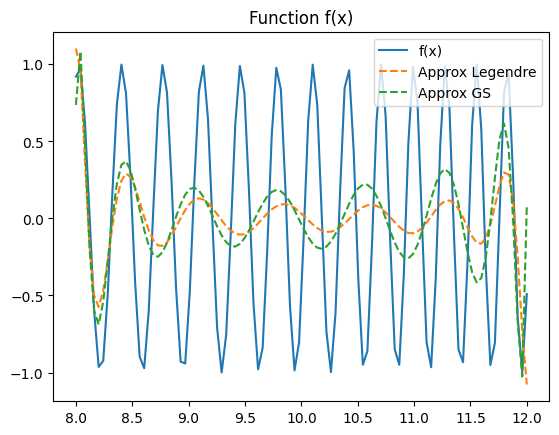

In [ ]:
n = 15
func = lambda x: - np.exp(-x) + np.sin(x**2)
a = 8
b = 12
phi = gram_schmidt(n, a, b)
x = np.linspace(a, b, 500) 

approx_l = LeastSquares(func, a, b, n).set_method("legendre").construct() 
approx_gs = LeastSquares(func, a, b, n, weight=lambda x: np.exp(-x)).set_method("gram_schmidt").construct() 

plt.plot(x, func(x), label='f(x)')
plt.plot(x, approx_l(x), '--', label='Approx Legendre')
plt.plot(x, approx_gs(x), '--', label='Approx GS')

plt.title('Function f(x)')
plt.legend()
plt.show()

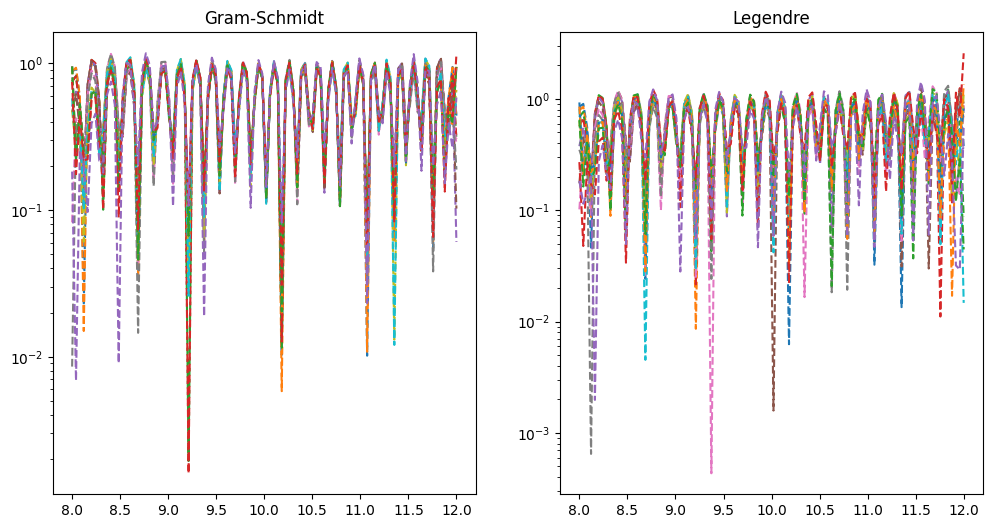

In [59]:
lsq_l = LeastSquares(func, a, b, n).set_method("legendre")
lsq_gs = LeastSquares(func, a, b, n, weight=lambda x: np.exp(-x)).set_method("gram_schmidt")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Gram-Schmidt')
ax[1].set_title('Legendre')
for i in range(1, n+1):
    approx_l = lsq_l.construct(i) 
    approx_gs = lsq_gs.construct(i) 
    ax[0].semilogy(x, np.abs(func(x) - approx_l(x)), '--', label='Approximation')
    ax[1].semilogy(x, np.abs(func(x) - approx_gs(x)), '--', label='Approximation')

plt.show()